In [1]:
# Script to look at the common reactions and find the ones that are most different
# Then take the 30 most different and generate 1000 cti files of the mixed models

In [134]:
import cantera as ct
import cantera.ck2cti
import rmgpy.chemkin
import numpy as np
import subprocess

import matplotlib.pyplot as plt

import time
import copy
import os

import scipy.stats

In [3]:
# load David's 2-BTP model, minus the halogens
# https://github.com/comocheng/halogen_models/tree/main/combustion_symposium_paper/supporting_material

RMG_chemkin_path = 'models/RMG_no_halogens/no_halogens.inp'
RMG_dictionary_path = 'models/RMG_no_halogens/no_halogens_dict.txt'
RMG_transport_path = 'models/RMG_no_halogens/no_halogens_tran.dat'
RMG_cti_path = 'models/RMG_no_halogens/no_halogens.cti'

RMG_species_list, RMG_reaction_list = rmgpy.chemkin.load_chemkin_file(RMG_chemkin_path, dictionary_path=RMG_dictionary_path, transport_path=RMG_transport_path)
RMG_gas = ct.Solution(RMG_cti_path)



In [6]:
# Load NIST model without halogens
NIST_cti_path = 'models/NIST_no_halogens/no_halogens.cti'
NIST_chemkin_path = 'models/NIST_no_halogens/no_halogens.inp'
NIST_dictionary_path = 'models/NIST_no_halogens/no_halogens_dict.txt'
NIST_transport_path = 'models/NIST_no_halogens/no_halogens_tran.dat'

NIST_gas = ct.Solution(NIST_cti_path)
NIST_dict = rmgpy.chemkin.load_species_dictionary(NIST_dictionary_path)
NIST_species_list, NIST_reaction_list = rmgpy.chemkin.load_chemkin_file(NIST_chemkin_path, dictionary_path=NIST_dictionary_path, transport_path=NIST_transport_path)


For species CH2OCH, discontinuity in cp/R detected at Tmid = 500.0
	Value computed using low-temperature polynomial:  8.393471510000001
	Value computed using high-temperature polynomial: 9.1801039121875

For species CH2OCH, discontinuity in h/RT detected at Tmid = 500.0
	Value computed using low-temperature polynomial:  42.199147089791666
	Value computed using high-temperature polynomial: 41.961461604875005

For species CH2OCH, discontinuity in s/R detected at Tmid = 500.0
	Value computed using low-temperature polynomial:  33.70692865946735
	Value computed using high-temperature polynomial: 33.51209988778391

For species C4H5-2, discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  47.65235236593109
	Value computed using high-temperature polynomial: 48.43623165666667

For species C4H5-2, discontinuity in s/R detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  52.42918829260522
	Value computed using high-temperature p

In [24]:
# Species Diff
common_species = []
RMG2NIST_mapping = {}
NIST2RMG_mapping = {}
for i, rmg_sp in enumerate(RMG_species_list):
    for j, nist_sp in enumerate(NIST_species_list):
        if rmg_sp.is_isomorphic(nist_sp):
            RMG2NIST_mapping[i] = j
            NIST2RMG_mapping[j] = i
            common_species.append([rmg_sp, nist_sp])
            break

# Reaction Diff
common_reactions = []
RMG2NIST_rxn_mapping = {}
NIST2RMG_rxn_mapping = {}
for i, rmg_rxn in enumerate(RMG_reaction_list):
    for j, nist_rxn in enumerate(NIST_reaction_list):
        if rmg_rxn.is_isomorphic(rmg_rxn):
            RMG2NIST_rxn_mapping[i] = j
            NIST2RMG_rxn_mapping[j] = i
            common_reactions.append([rmg_rxn, nist_rxn])
            break


In [26]:
# count the common reactions:

print(len(RMG2NIST_mapping))
print(len(RMG2NIST_rxn_mapping))
print(len(common_species))
print(len(common_reactions))

45
825
45
825


In [8]:
# Convert the NIST species in the reactions to RMG species, but keep the NIST kinetics
def NIST2RMG(nist_reaction):
    rmg_reaction = copy.deepcopy(nist_reaction)
    reactants = []
    for reactant in nist_reaction.reactants:
        NIST_species_index = NIST_species_list.index(reactant)
        reactants.append(RMG_species_list[NIST2RMG_mapping[NIST_species_index]])
    rmg_reaction.reactants = reactants
    
    products = []
    for product in nist_reaction.products:
        NIST_species_index = NIST_species_list.index(product)
        products.append(RMG_species_list[NIST2RMG_mapping[NIST_species_index]])
    rmg_reaction.products = products
    
    return rmg_reaction


In [18]:
common_reactions[0][0].get_rate_coefficient(1000)

44372.29727050111

In [101]:
# define error as  (ln(k_nist) - ln(k_rmg))^2
def calc_kinetics_error(nist_rxn, rmg_rxn):
    T = np.linspace(300, 3000, 101)
    error = 0
    for i in range(0, len(T)):
        
        nist_rate = nist_rxn.get_rate_coefficient(T[i], 101325)
        rmg_rate = rmg_rxn.get_rate_coefficient(T[i], 101325)
#         if np.isnan(rmg_rate):
#             nist_rate = nist_rxn.kinetics.get_rate_coefficient(T[i], 101325)
#             rmg_rate = rmg_rxn.kinetics.get_rate_coefficient(T[i], 101325)
        error += np.float_power(np.log(nist_rate) - np.log(rmg_rate), 2.0)
    return error

In [36]:
len(common_reactions)

825

In [102]:
# find the reactions with the most different kinetics as defined by a mean squared error in the temperature range 300-1000K
errors = np.zeros(len(common_reactions))
for i, entry in enumerate(common_reactions):
    errors[i] = calc_kinetics_error(entry[1], entry[0])
#     print(i, errors[i])

In [103]:
# sort the reactions
order = np.argsort(errors)


In [105]:
def plot_kinetics(kinetics, labels=None):
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    T = np.linspace(300, 3000, 1001)
    for kinetic in kinetics:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = kinetic.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log(k))

    plt.legend(labels)
    plt.show()

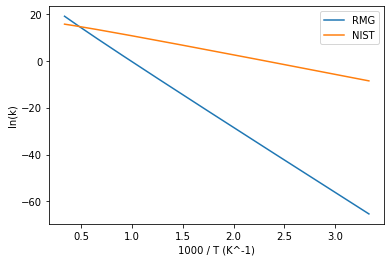

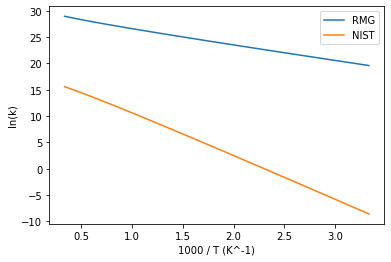

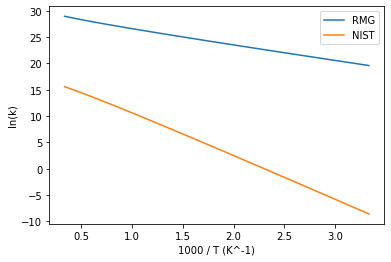

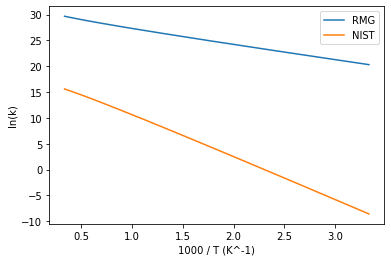

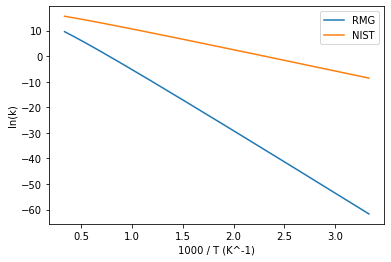

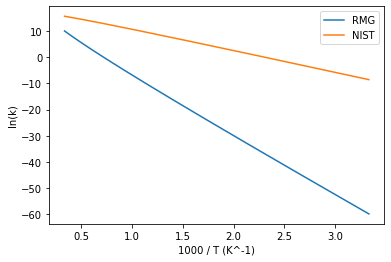

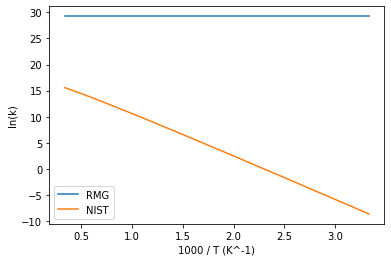

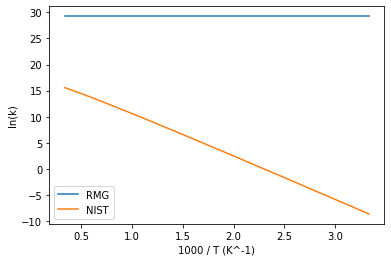

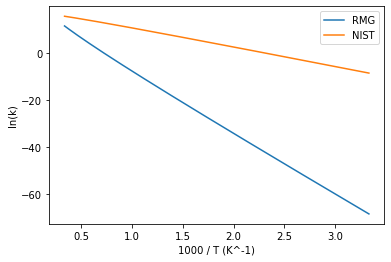

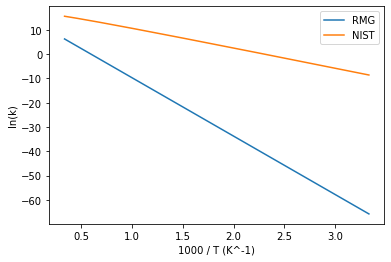

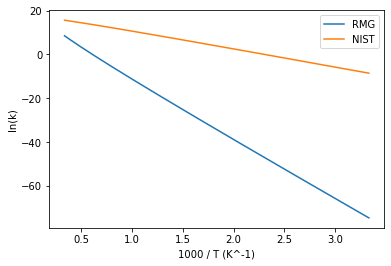

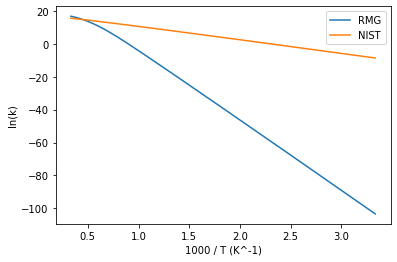

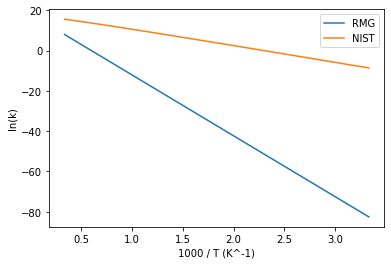

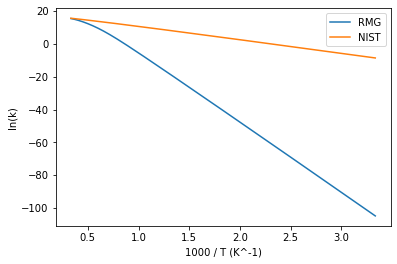

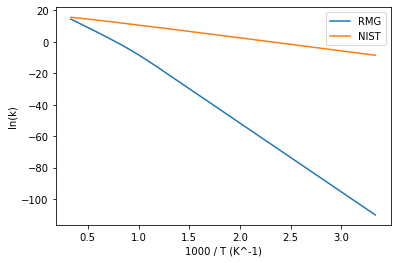

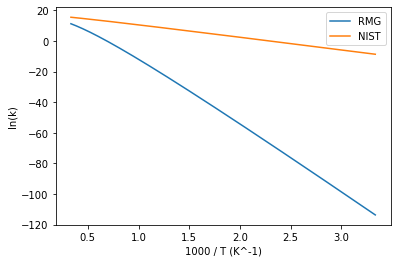

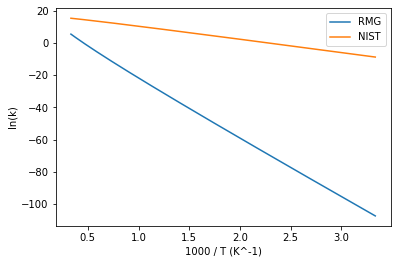

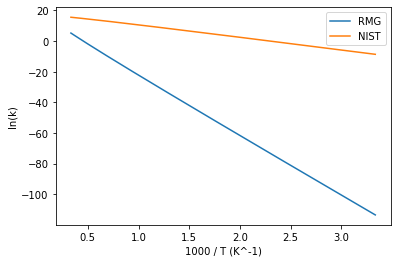

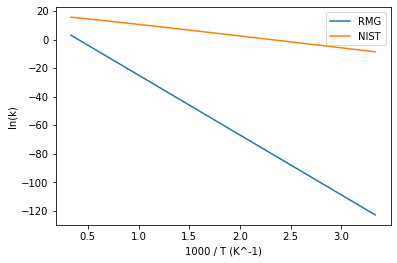

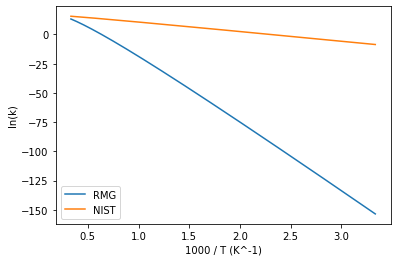

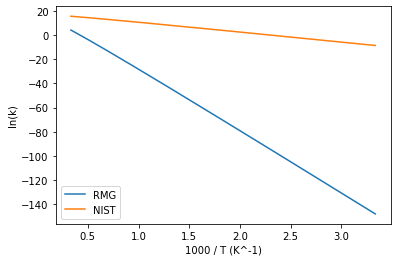

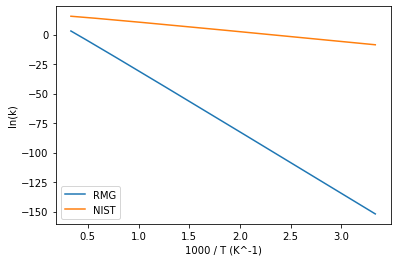

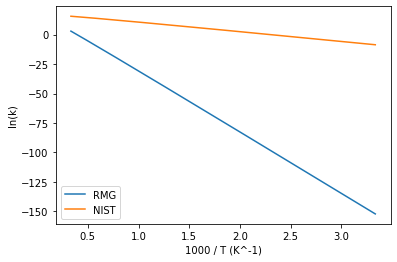

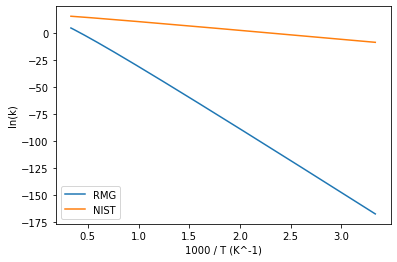

In [106]:
%matplotlib inline
i = order[3]
for j in range(800, 824):
    i = order[j]
    plot_kinetics(common_reactions[i], ['RMG', 'NIST'])
#     time.sleep(1.0)



In [140]:
# select the 30 most different reactions to try mixing
reactions_to_mix = []
reactions_to_mix_rmg_indices = []
N = 30
for i in range(-N, 0):
    index = order[i]
    reactions_to_mix.append(common_reactions[index])
    reactions_to_mix_rmg_indices.append(RMG_reaction_list.index(common_reactions[index][0]))
#     print(common_reactions[index][0])
# print(len(reactions_to_mix))

print(reactions_to_mix_rmg_indices)

[478, 623, 610, 228, 509, 514, 409, 397, 612, 170, 144, 797, 767, 257, 26, 421, 222, 241, 221, 231, 80, 383, 614, 348, 644, 4, 6, 5, 11, 12]


In [132]:
# Generate the random numbers to do the mixing
num_flame_speeds = 2 ** 11
sampler = scipy.stats.qmc.Sobol(d=N, scramble=True, seed=400)
sample = sampler.random(num_flame_speeds)
sample.shape

(2048, 30)

In [70]:
# Create a new model using all values from the NIST model that are common - change reactions only
RMG_NIST_path = os.path.join('models', 'RMG_NIST')
os.makedirs(RMG_NIST_path, exist_ok=True)

# RMG_NIST_species = []
RMG_NIST_species = RMG_species_list
RMG_NIST_reactions = []
# for i, species in enumerate(RMG_species_list):
#     if i in RMG2NIST_mapping.keys():
#         RMG_NIST_species.append(NIST_species_list[RMG2NIST_mapping[i]])
#     else:
#         RMG_NIST_species.append(species)
        
for i, rxn in enumerate(RMG_reaction_list):
    if i in RMG2NIST_rxn_mapping.keys():
        RMG_NIST_reactions.append(NIST2RMG(NIST_reaction_list[RMG2NIST_rxn_mapping[i]]))
    else:
        RMG_NIST_reactions.append(rxn)


        
chemkin_file = os.path.join(RMG_NIST_path, 'RMG_NIST.inp')
transport_file = os.path.join(RMG_NIST_path, 'RMG_NIST_tran.dat')
        

rmgpy.chemkin.save_chemkin_file(chemkin_file, RMG_NIST_species, RMG_NIST_reactions, verbose=True, check_for_duplicates=True)
rmgpy.chemkin.save_transport_file(transport_file, RMG_NIST_species)
rmgpy.chemkin.save_species_dictionary(os.path.join(RMG_NIST_path, 'RMG_NIST_dict.txt'), RMG_NIST_species)

In [71]:
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport_file}'])

# cantera.ck2cti.convertMech(os.path.join(RMG_NIST_path, 'RMG_NIST.inp'), transport=os.path.join(RMG_NIST_path, 'RMG_NIST_tran.dat'))

Wrote CTI mechanism file to 'models/RMG_NIST/RMG_NIST.cti'.
Mechanism contains 98 species and 833 reactions.
Validating mechanism...CanteraWarning: Troe::init: Unexpected parameter value T2=0. Omitting exp(T2/T) term from falloff expression. To suppress this warning, remove value for T2 from the input file. In the unlikely case that the exp(T2/T) term should be included with T2 effectively equal to 0, set T2 to a sufficiently small value (i.e. T2 < 1e-16).
PASSED.


CompletedProcess(args=['ck2cti', '--input=models/RMG_NIST/RMG_NIST.inp', '--transport=models/RMG_NIST/RMG_NIST_tran.dat'], returncode=0)

In [74]:
# create a model that only has RMG-NIST common reactions
common_path = os.path.join('models', 'common')
os.makedirs(common_path, exist_ok=True)

common_species = []
common_reactions = []
for i in range(0, len(RMG_species_list)):
    if i in RMG2NIST_mapping.keys():
        common_species.append(RMG_species_list[i])

for i in range(0, len(RMG_reaction_list)):
    if i in RMG2NIST_rxn_mapping.keys():
        common_reactions.append(RMG_reaction_list[i])

    
chemkin_file = os.path.join(common_path, 'common.inp')
transport_file = os.path.join(common_path, 'common.dat')
        

rmgpy.chemkin.save_chemkin_file(chemkin_file, common_species, common_reactions, verbose=True, check_for_duplicates=True)
rmgpy.chemkin.save_transport_file(transport_file, common_species)
rmgpy.chemkin.save_species_dictionary(os.path.join(common_path, 'common_dict.txt'), common_species)

subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport_file}'])

Wrote CTI mechanism file to 'models/common/common.cti'.
Mechanism contains 45 species and 246 reactions.
Validating mechanism...PASSED.


CompletedProcess(args=['ck2cti', '--input=models/common/common.inp', '--transport=models/common/common.dat'], returncode=0)

In [24]:
dir(cantera.ck2cti)

['Arrhenius',
 'Avogadro',
 'Chebyshev',
 'ChemicallyActivated',
 'ENERGY_UNITS',
 'Falloff',
 'InputParseError',
 'KineticsData',
 'KineticsModel',
 'MultiNASA',
 'NASA',
 'PDepArrhenius',
 'Parser',
 'QUANTITY_UNITS',
 'Reaction',
 'Species',
 'Sri',
 'Surface',
 'SurfaceArrhenius',
 'ThermoModel',
 'ThirdBody',
 'TransportData',
 'Troe',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_open',
 'compatible_quantities',
 'contains',
 'convertMech',
 'defaultdict',
 'fortFloat',
 'get_index',
 'getopt',
 'itertools',
 'logging',
 'main',
 'np',
 'open',
 'os',
 'print_function',
 're',
 'script_entry_point',
 'string_types',
 'strip_nonascii',
 'sys']

In [5]:
len(RMG_reaction_list)

825